In [1]:
cd "/content/drive/MyDrive/Colab Notebooks/CS7643_A3"

/content/drive/MyDrive/Colab Notebooks/CS7643_A3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# load data

In [2]:
# Load your data
dataset = "data_RICE"
X_path = dataset + "/X.csv"
y_path = dataset + "/y.csv"
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

In [3]:
X.columns

Index(['AREA', 'PERIMETER', 'MAJORAXIS', 'MINORAXIS', 'ECCENTRICITY',
       'CONVEX_AREA', 'EXTENT'],
      dtype='object')

In [4]:
y

CLASS
0         0
1         0
2         0
3         0
4         0
...     ...
3805      1
3806      1
3807      1
3808      1
3809      1

[3810 rows x 1 columns]

## determine optimal components

If you want to assess the quality of the t-SNE embedding, you typically do it visually or by evaluating clustering performance. However, if you still want to proceed with the reconstruction error approach, you might need to use another method for dimensionality reduction, like PCA or ICA.

## Scale

In [5]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std.shape

from sklearn.manifold import TSNE

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Initialize t-SNE objects with the desired number of components
tsne_1 = TSNE(n_components=1)
tsne_2 = TSNE(n_components=2)
tsne_3 = TSNE(n_components=3)

# Fit the t-SNE models to the standardized data
X_tsne_1 = tsne_1.fit_transform(X_std)
X_tsne_2 = tsne_2.fit_transform(X_std)
X_tsne_3 = tsne_3.fit_transform(X_std)

## clustering

### Hierarchical Clustering with Agglomerative Clustering
Hierarchical Clustering is a family of clustering algorithms that create a hierarchy of clusters. Agglomerative Clustering is a type of hierarchical clustering that starts with each data point as a separate cluster and then recursively merges the closest pairs of clusters until a stopping criterion is met.

Agglomerative Clustering works by calculating the distance between each pair of data points and merging the two closest points into a single cluster. The algorithm then recalculates the distance between this new cluster and all the other clusters, and continues to merge the closest pairs of clusters until all the data points are in a single cluster or the desired number of clusters is reached.

One of the advantages of Agglomerative Clustering is that it can create clusters of varying sizes and shapes, and it can be used with a variety of distance metrics. It is also relatively easy to interpret the results of the clustering.

One of the disadvantages of Agglomerative Clustering is that it can be **computationally expensive for large datasets**, as it requires calculating the distance between each pair of data points. It can also be sensitive to the choice of distance metric and the stopping criterion used to determine the number of clusters.

#### Dendrogram

In [6]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
                                    [model.children_, model.distances_, counts]
                                    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

AgglomerativeClustering(distance_threshold=10, n_clusters=None)


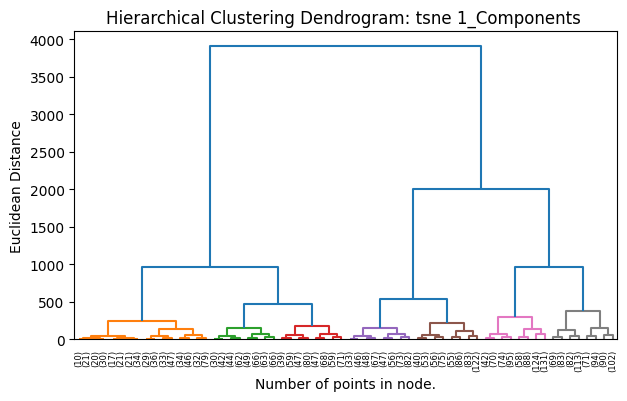

AgglomerativeClustering(distance_threshold=10, n_clusters=None)


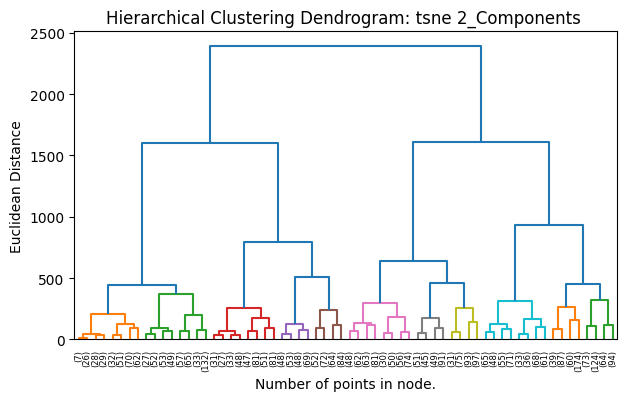

AgglomerativeClustering(distance_threshold=10, n_clusters=None)


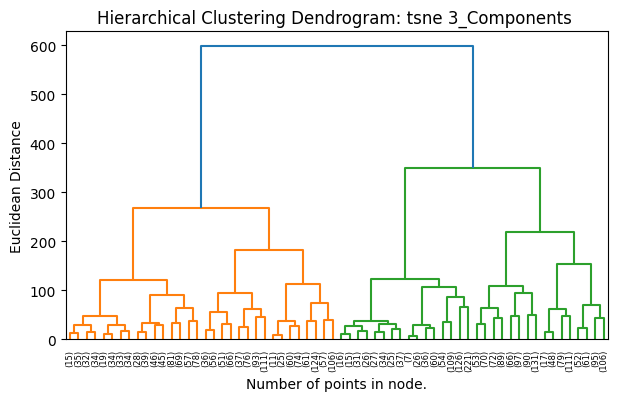

In [ ]:
# we dont specify n_cluster to generate dendrogram\d
dr= "tsne"
for n, X_tsne in enumerate([X_tsne_1, X_tsne_2, X_tsne_3]):
    agg_model = AgglomerativeClustering(distance_threshold=10, n_clusters=None)
    agg_model.fit(X_tsne)
    print(agg_model)
    plt.figure(figsize=(7, 4))
    plt.tight_layout()
    plt.title(f"Hierarchical Clustering Dendrogram: {dr} {n+1}_Components ")
    # plot the top levels of the dendrogram
    plot_dendrogram(agg_model, truncate_mode="level", p=5, color_threshold=400)
    plt.axhline(y=10000, color='red')
    plt.xlabel("Number of points in node.")
    plt.ylabel("Euclidean Distance")
    plt.savefig(f"plot/dendrogram_{dr}_{n+1}_components.png")
    plt.show()

#### Silhouette analysis
what is Silhouette score
1: indicates that the data point is well-matched to its own cluster and poorly-matched to neighboring clusters.

0: indicates that the data point is on or very close to the decision boundary between two neighboring clusters.

-1: Means clusters are assigned in the wrong way.


Quantifying the quality of clustering via silhouette plots The silhouette score is calculated for each data point using the following formula:
silhouette score = (b - a) / max(a, b)

Where:

a is the average distance between a data point and all other points in the same cluster.
b is the average distance between a data point and all points in the nearest neighboring cluster.

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

def silhouette_analysis(model_labels = y, X = X_std, model = "Hierarchical", dataset = dataset, dr= "tsne" ):

    cluster_labels = np.unique(model_labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X,
                       model_labels,
                       metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[model_labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
        c_silhouette_vals,
        height=1.0,
        edgecolor='none',
        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    # add the average silhouette coefficient to the plot (dotted line)
    silhouette_avg = np.round(np.mean(silhouette_vals), 2)
    plt.axvline(silhouette_avg, color="red", linestyle="--")

    plt.yticks(yticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f"{dataset}_{model}_{len(cluster_labels)} clusters_{dr}_{X.shape[1]}, Avesilhouette coefficient={silhouette_avg}")
    plt.savefig(f"plot/silhouette_{dataset}_{model}_{len(cluster_labels)}_clusters_{dr}_{X.shape[1]}.png")
    plt.show()

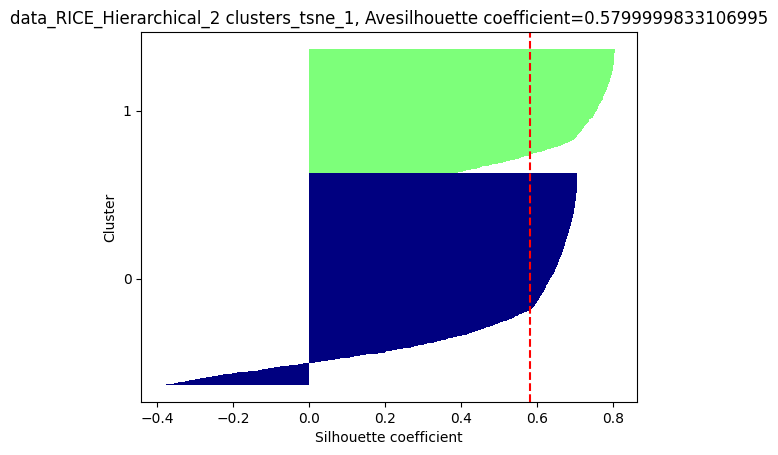

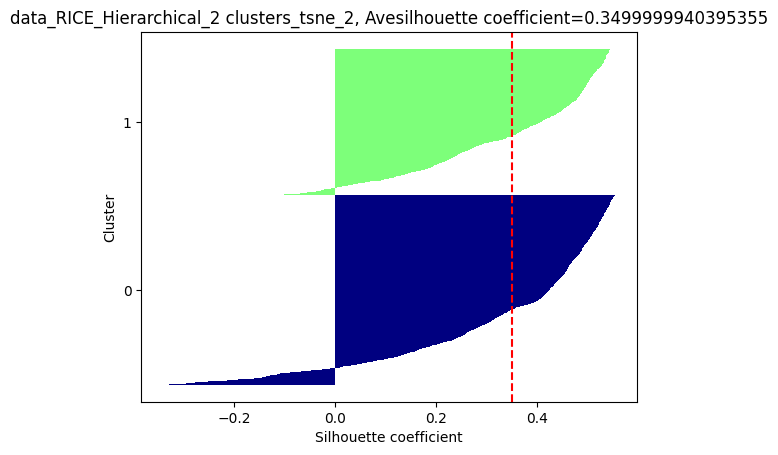

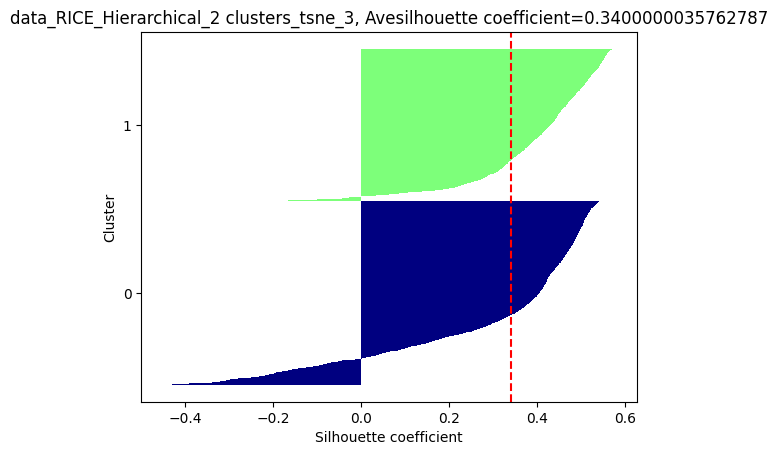

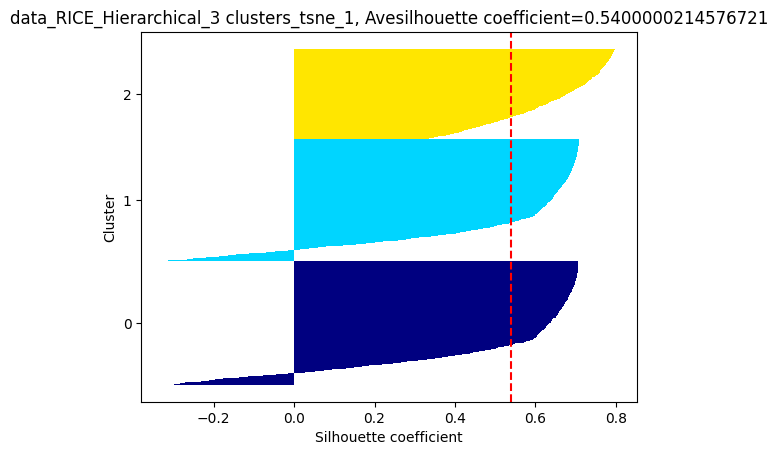

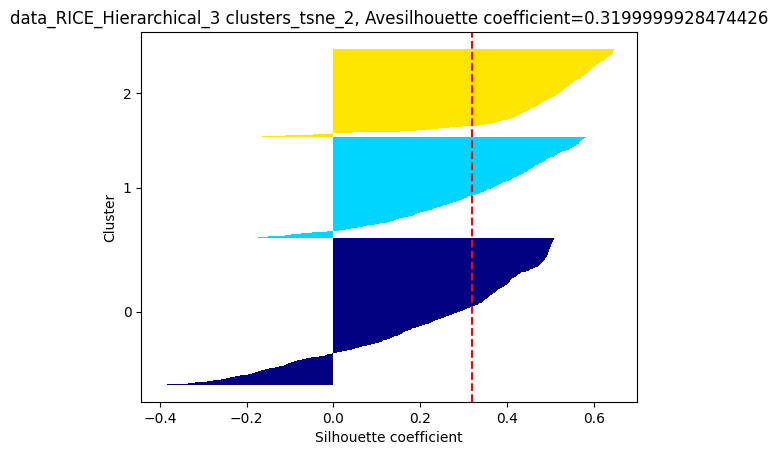

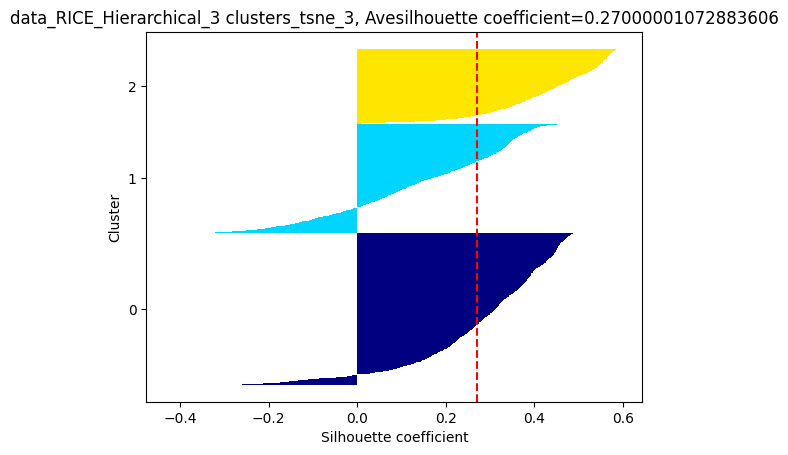

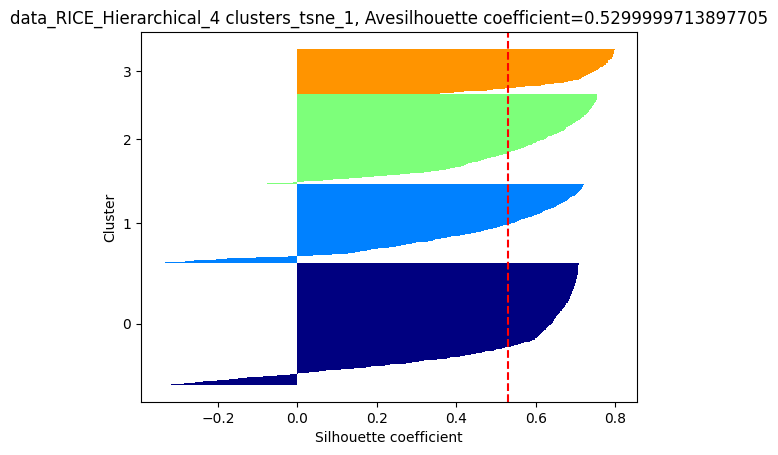

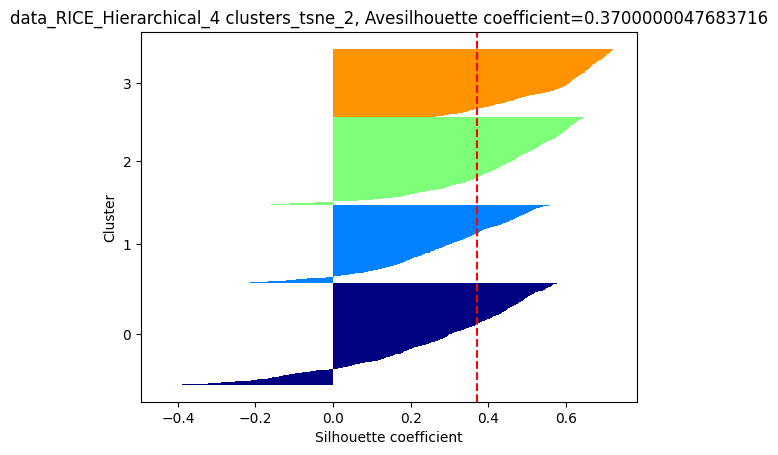

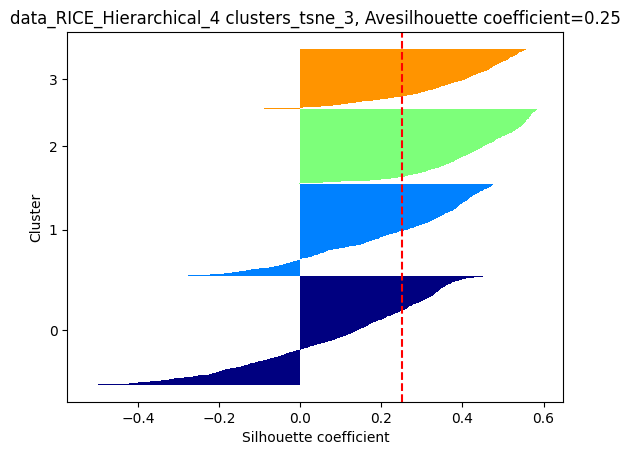

In [ ]:
for i in range(2,5):
  dr= "tsne"
  for n, X_tsne in enumerate([X_tsne_1, X_tsne_2, X_tsne_3]):
      agglo = AgglomerativeClustering(n_clusters=i,
                                      metric='euclidean',
                                      linkage='ward')
      agglo = agglo.fit(X_tsne)
      silhouette_analysis(agglo.labels_,X_tsne, model = "Hierarchical",dr= dr)

#### visualize clusters in new tsne space

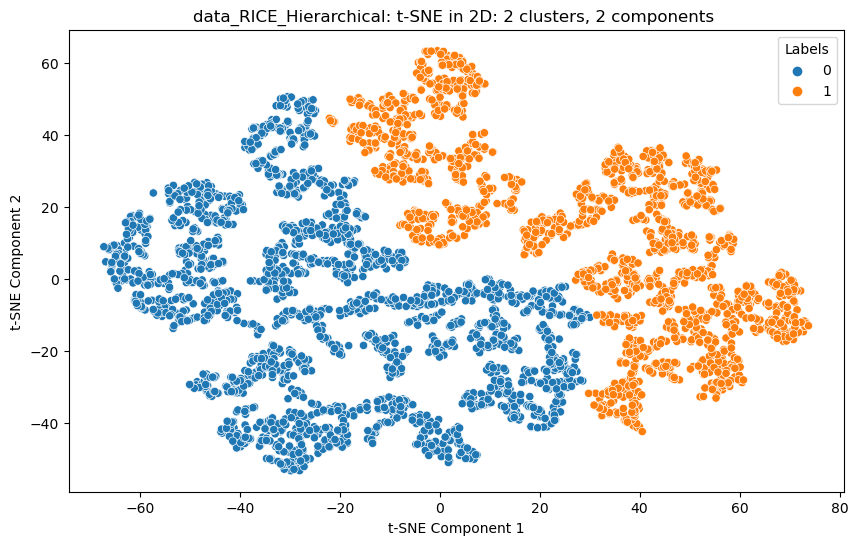

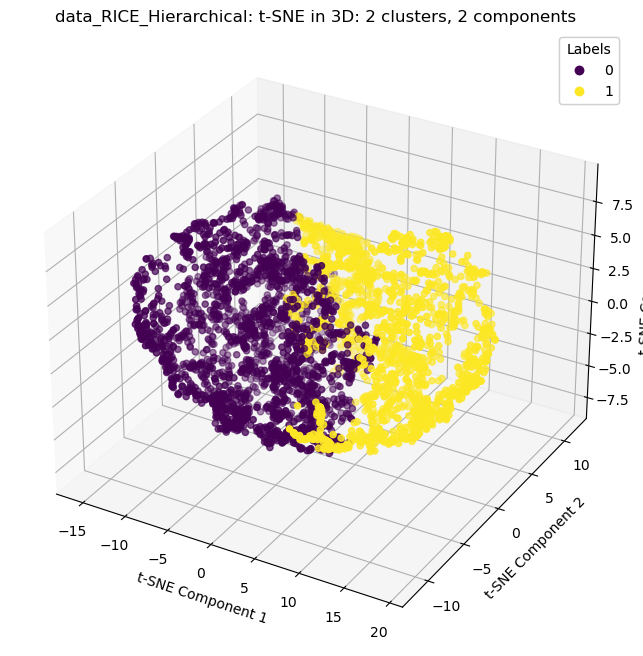

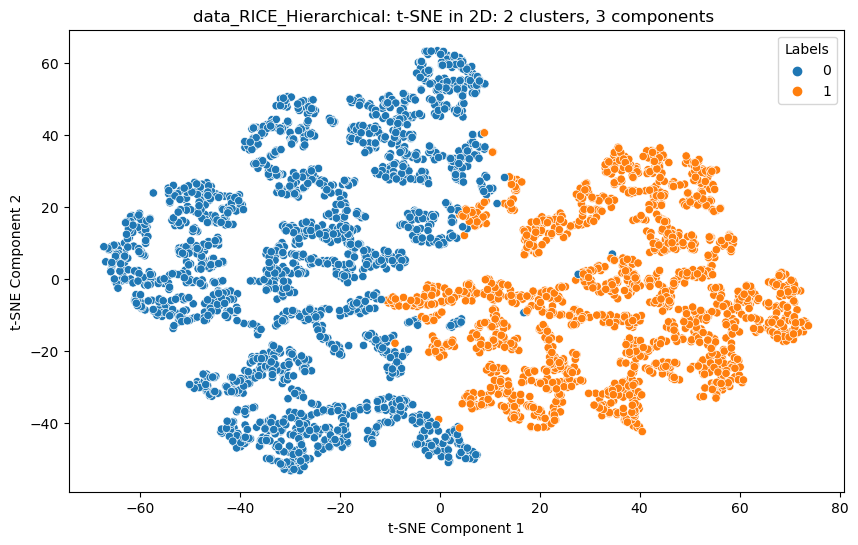

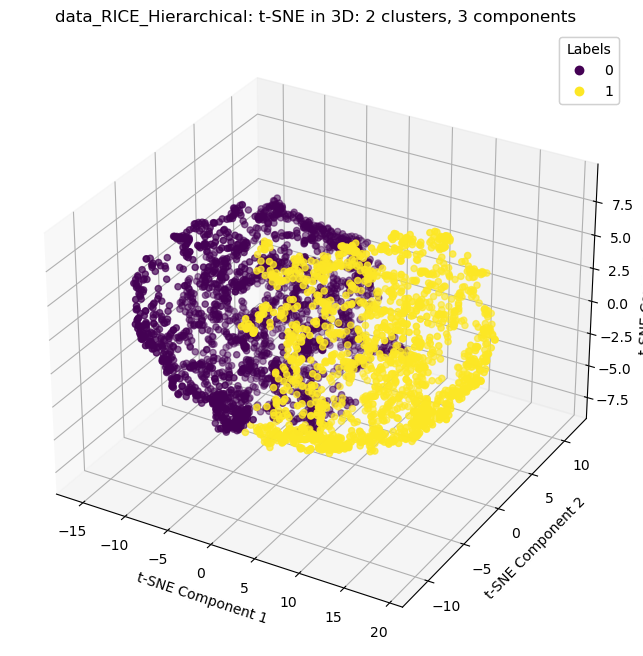

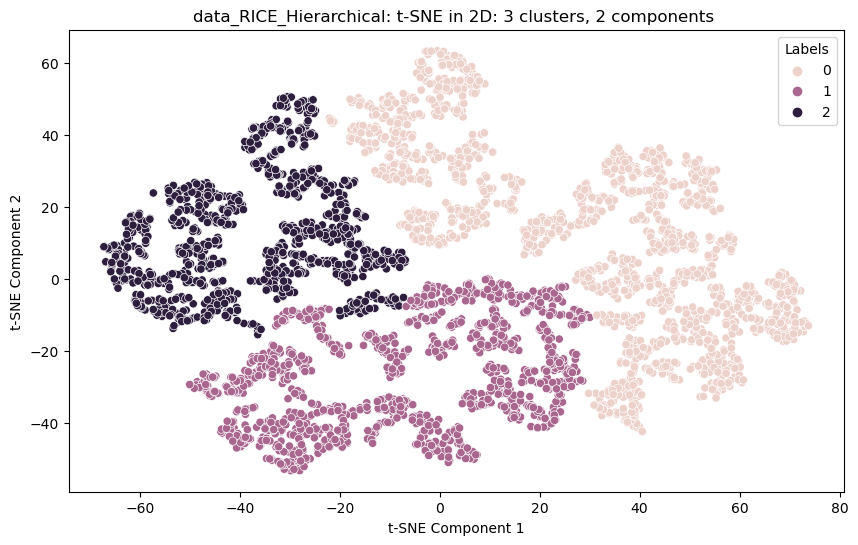

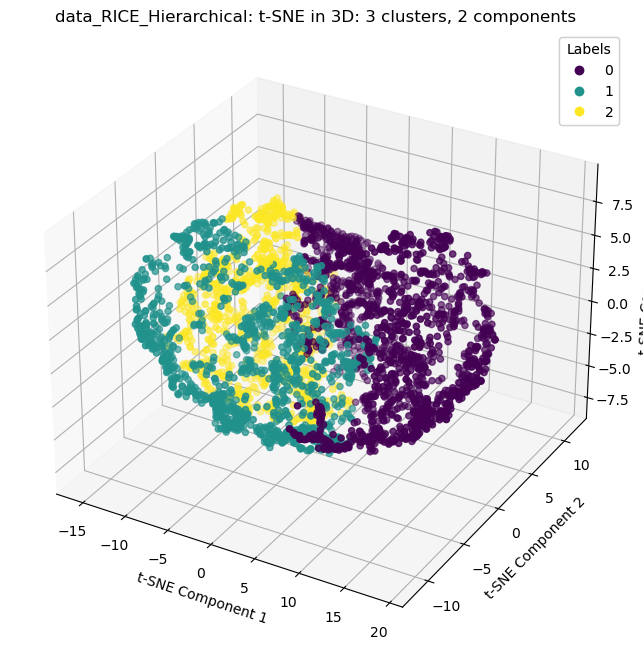

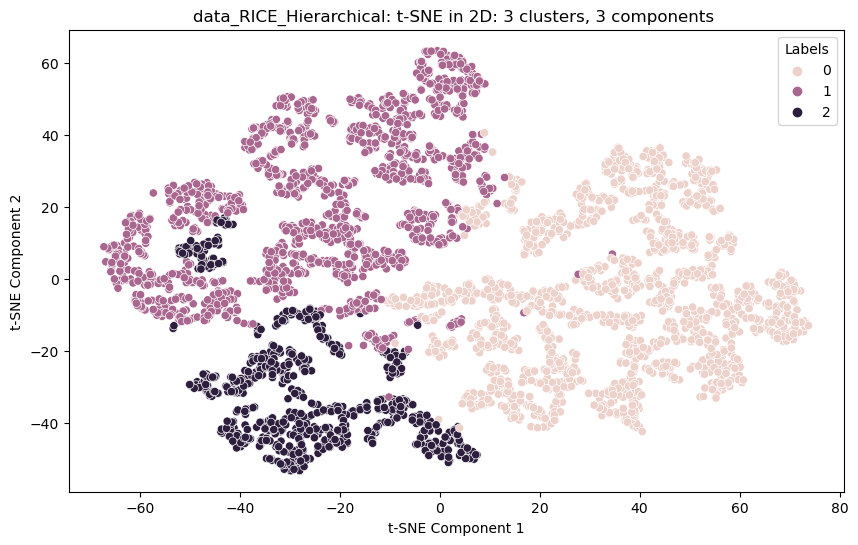

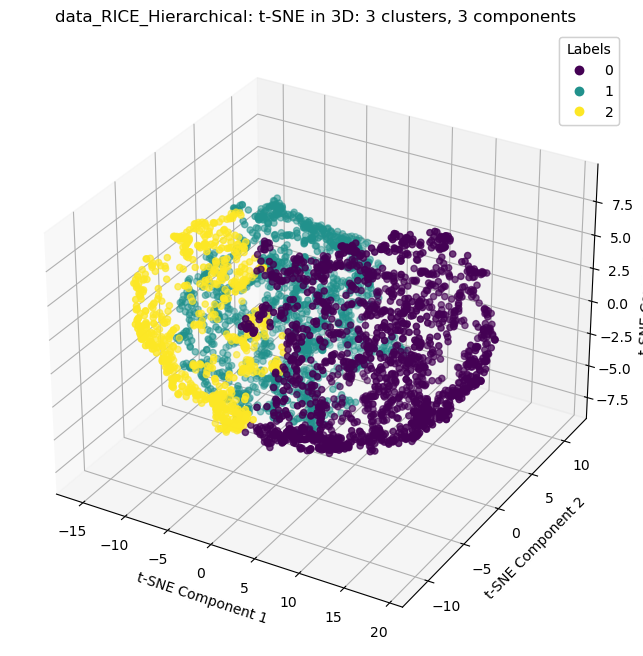

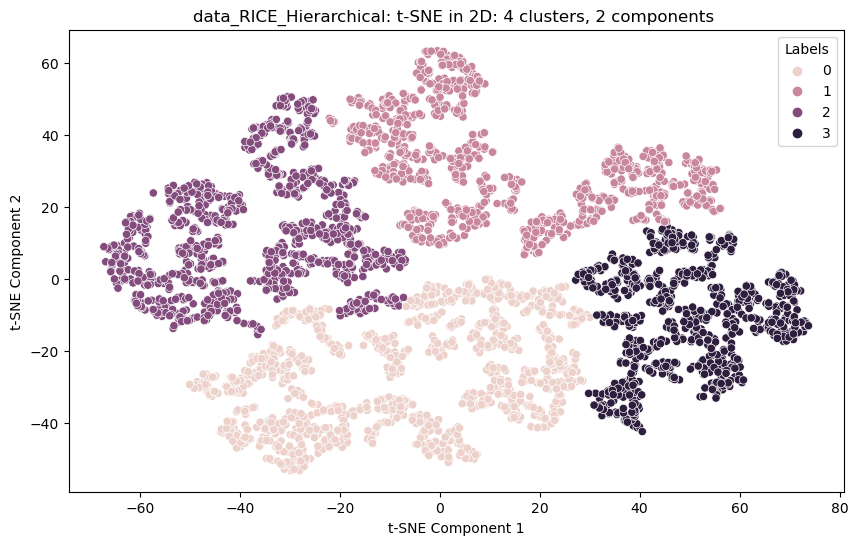

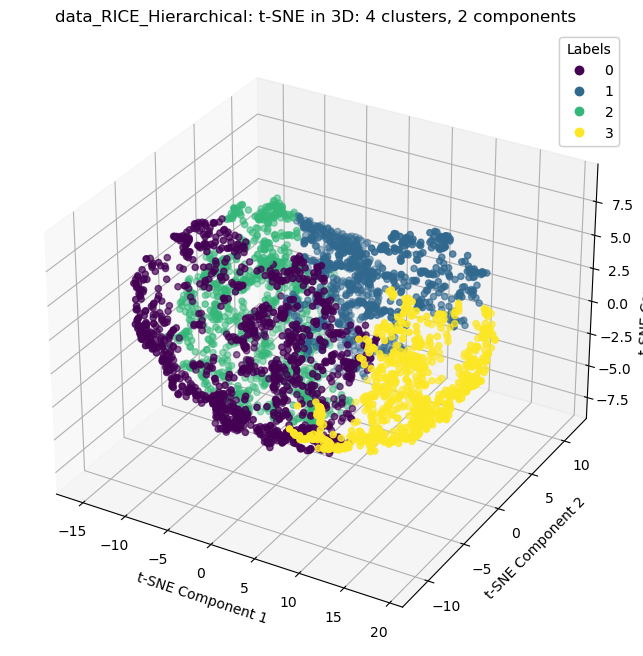

KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std.shape

from sklearn.manifold import TSNE

n_clusters = 2
n_comp = 2
dataset = dataset
modeltype = "Hierarchical"

for n_clusters in range(2,5):
  for n_comp in range(2,min(X.shape[1], 4)):

    tsne = TSNE(n_components=n_comp )
    X_tsne = tsne.fit_transform(X_std)

    agglo = AgglomerativeClustering(n_clusters=n_clusters,
                                          metric='euclidean',
                                          linkage='ward') # n pf clusters
    agglo.fit(X_tsne) # using how many componentes generated from t-SNE
    labels = agglo.labels_

    # Visualize t-SNE embeddings in 2D with hue by labels
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_tsne_2[:, 0], y=X_tsne_2[:, 1], hue=labels)
    plt.title(f'{dataset}_{modeltype}: t-SNE in 2D: {n_clusters} clusters, {n_comp} components ')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Labels')
    plt.savefig("Images/"+ f'{dataset}_{modeltype}_2D_{n_clusters}_clusters_{n_comp}_components.png')
    plt.show()

    # Visualize t-SNE embeddings in 3D with hue by labels
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_tsne_3[:, 0], X_tsne_3[:, 1], X_tsne_3[:, 2], c=labels, cmap='viridis')
    ax.set_title(f'{dataset}_{modeltype}: t-SNE in 3D: {n_clusters} clusters, {n_comp} components ')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    legend = ax.legend(*scatter.legend_elements(), title="Labels", loc="upper right")
    ax.add_artist(legend)
    plt.savefig("Images/"+ f'{dataset}_{modeltype}_3D_{n_clusters}_clusters_{n_comp}_components.png')
    plt.show()

### accuracy comparison

Classification Report-data_RICE-Hierarchical-tsne1:
              precision    recall  f1-score   support

           0       0.14      0.21      0.17      1630
           1       0.08      0.05      0.06      2180

    accuracy                           0.12      3810
   macro avg       0.11      0.13      0.11      3810
weighted avg       0.10      0.12      0.11      3810



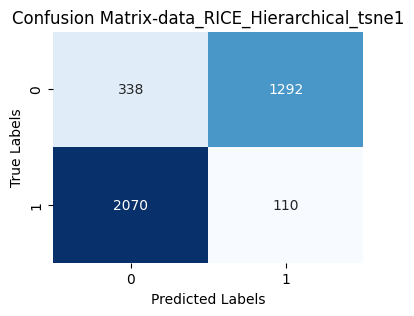

Classification Report-data_RICE-Hierarchical-tsne2:
              precision    recall  f1-score   support

           0       0.22      0.29      0.25      1630
           1       0.30      0.23      0.26      2180

    accuracy                           0.26      3810
   macro avg       0.26      0.26      0.26      3810
weighted avg       0.27      0.26      0.26      3810



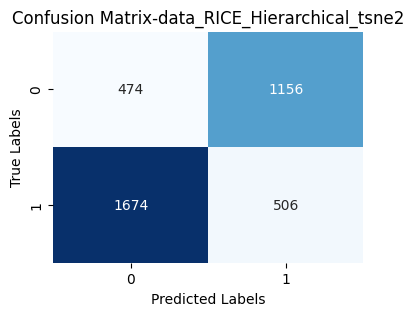

Classification Report-data_RICE-Hierarchical-tsne3:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85      1630
           1       0.97      0.77      0.86      2180

    accuracy                           0.86      3810
   macro avg       0.87      0.87      0.86      3810
weighted avg       0.88      0.86      0.86      3810



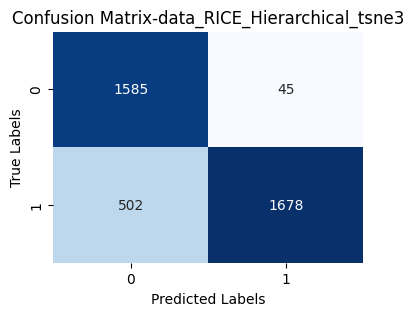

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model = "Hierarchical"
dr= "tsne"
for n, X_tsne in enumerate([X_tsne_1, X_tsne_2, X_tsne_3]):
  # we decide choose two clusters
  agglo_2_clusters = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
  agglo_2_clusters = agglo_2_clusters.fit(X_tsne)

  # compare actual vs predicted results
  actual_labels = y
  pred_lables = agglo_2_clusters.labels_


  print(f"Classification Report-{dataset}-{model}-{dr}{n+1}:")
  print(classification_report(actual_labels, pred_lables))

  # Generate confusion matrix
  plt.figure(figsize=(4, 3))
  cm = confusion_matrix(actual_labels, pred_lables)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.title(f"Confusion Matrix-{dataset}_{model}_{dr}{n+1}")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.savefig(f"plot/confusionMatrix_{dataset}_{model}_{dr}{n+1}.png")
  plt.show()
  print("========================================")

### Gaussian Mixture Model (GMM) Clustering
Gaussian Mixture Model (GMM) Clustering is a probabilistic clustering algorithm that assumes that the data points are generated from a mixture of Gaussian distributions. Each Gaussian distribution represents a cluster in the data, and the GMM algorithm estimates the parameters of the Gaussians to fit the data.

The GMM algorithm works by first initializing the parameters of the Gaussians, including their means, covariances, and weights. It then iteratively updates the parameters to maximize the likelihood of the data given the Gaussian mixture model. This is done using an Expectation-Maximization (EM) algorithm, where the "Expectation" step estimates the probability of each data point belonging to each Gaussian, and the "Maximization" step updates the parameters of each Gaussian based on these probabilities.

One of the advantages of GMM Clustering is that it can handle non-linearly separable data and can create clusters of varying sizes and shapes. It also provides a probabilistic interpretation of the clustering, where each data point is assigned a probability of belonging to each cluster.

One of the disadvantages of GMM Clustering is that it can be computationally expensive for large datasets, as it requires estimating the parameters of each Gaussian for each iteration of the algorithm. It can also be sensitive to the choice of the number of Gaussians used to model the data, which may not be known beforehand.

#### silouettes analysis

In [ ]:
from sklearn.metrics import silhouette_samples
from matplotlib import cm

def silhouette_analysis(model_labels = y, X = X_std, model = "GMM", dataset = dataset, dr="tsne" ):

    cluster_labels = np.unique(model_labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X,
                       model_labels,
                       metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[model_labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / len(cluster_labels))
        plt.barh(range(y_ax_lower, y_ax_upper),
        c_silhouette_vals,
        height=1.0,
        edgecolor='none',
        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    # add the average silhouette coefficient to the plot (dotted line)
    silhouette_avg = round(np.mean(silhouette_vals),2)
    plt.axvline(silhouette_avg, color="red", linestyle="--")

    plt.yticks(yticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title(f"{dataset}_{model}_{len(cluster_labels)} clusters_{dr}_{X.shape[1]}, Avesilhouette coefficient={round(silhouette_avg,2)}")
    plt.savefig(f"plot/silhouette_{dataset}_{model}_{len(cluster_labels)}_clusters_{dr}_{X.shape[1]}.png")
    plt.show()

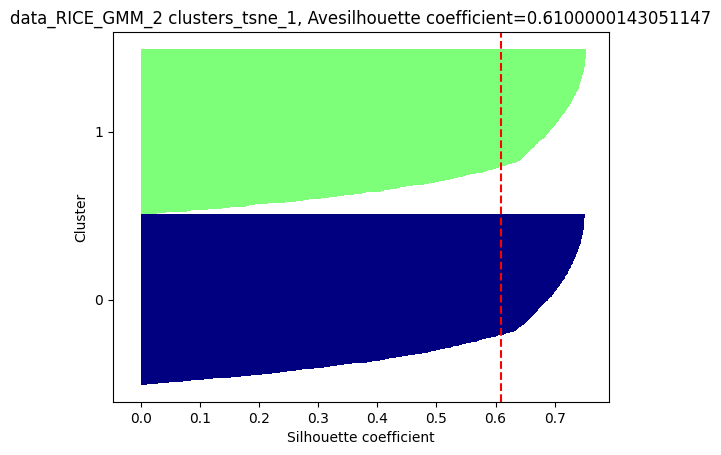

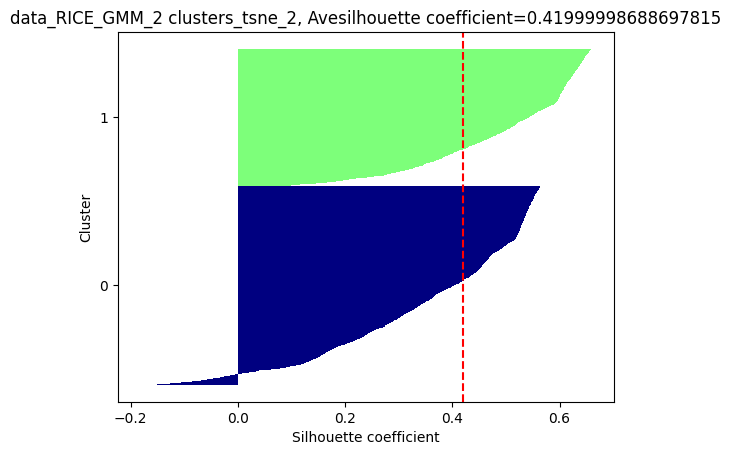

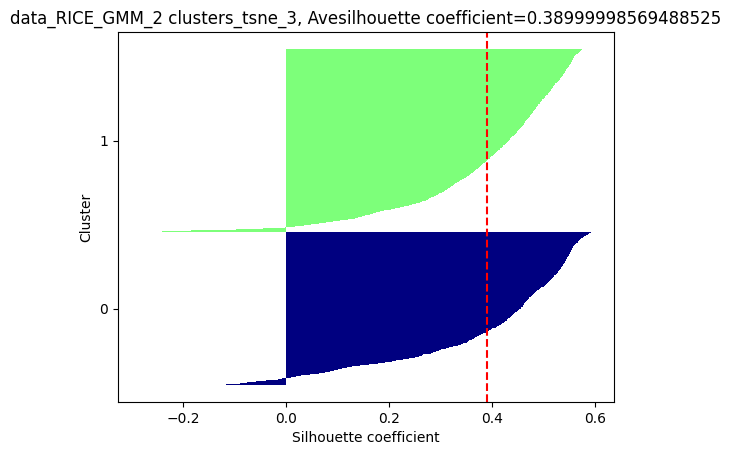

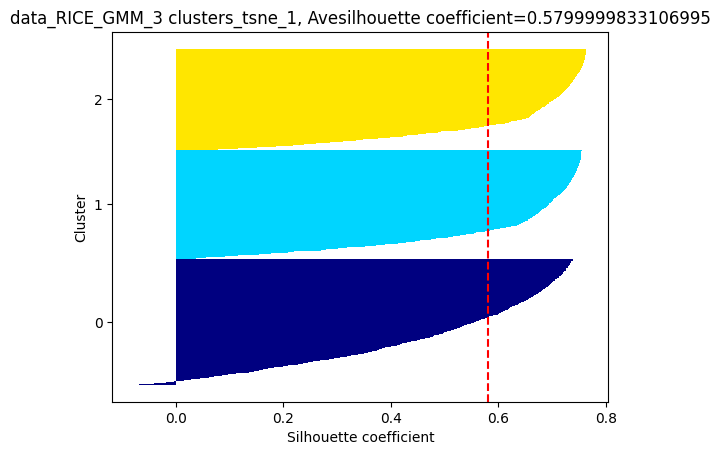

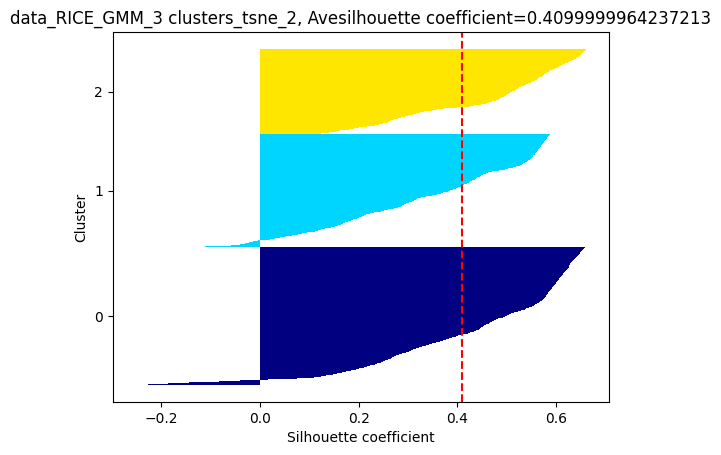

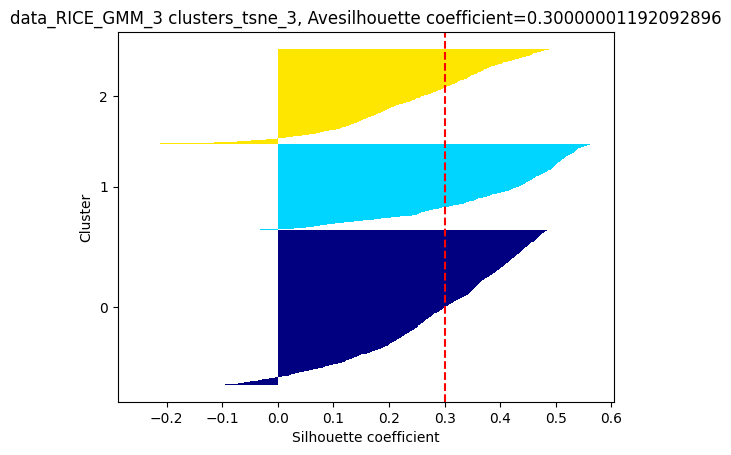

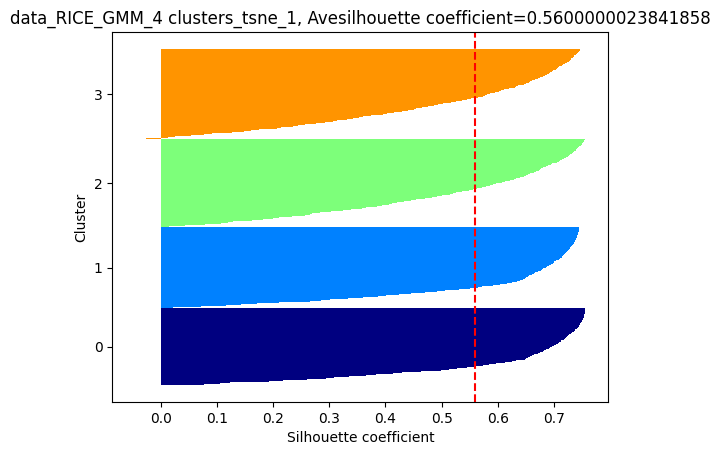

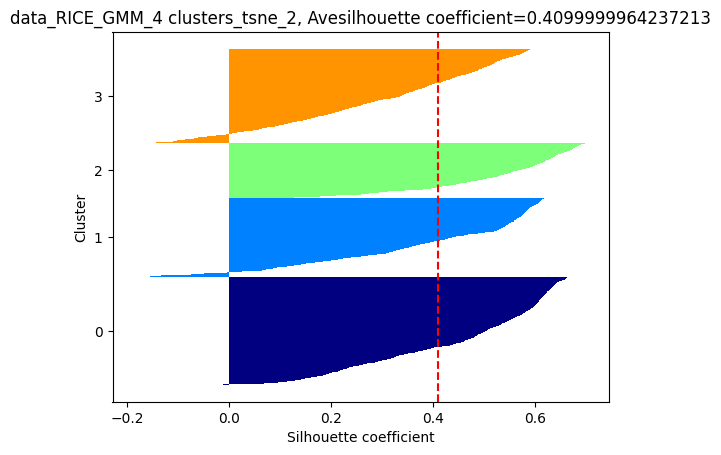

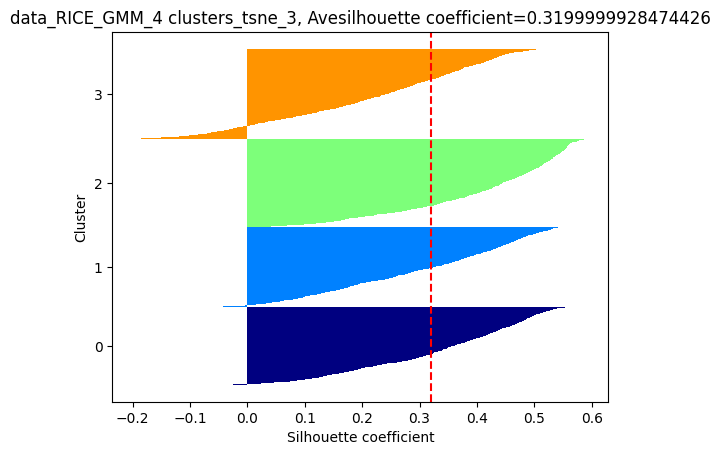

In [ ]:
for i in range(2,5):
  dr= "tsne"
  for n, X_tsne in enumerate([X_tsne_1, X_tsne_2, X_tsne_3]):
    GMM = GaussianMixture(n_components=i)
    GMM.fit(X_tsne)
    labels = GMM.predict(X_tsne)
    silhouette_analysis(labels,X_tsne, model = "GMM",dr = dr)

#### visualize clusters in new tsne space

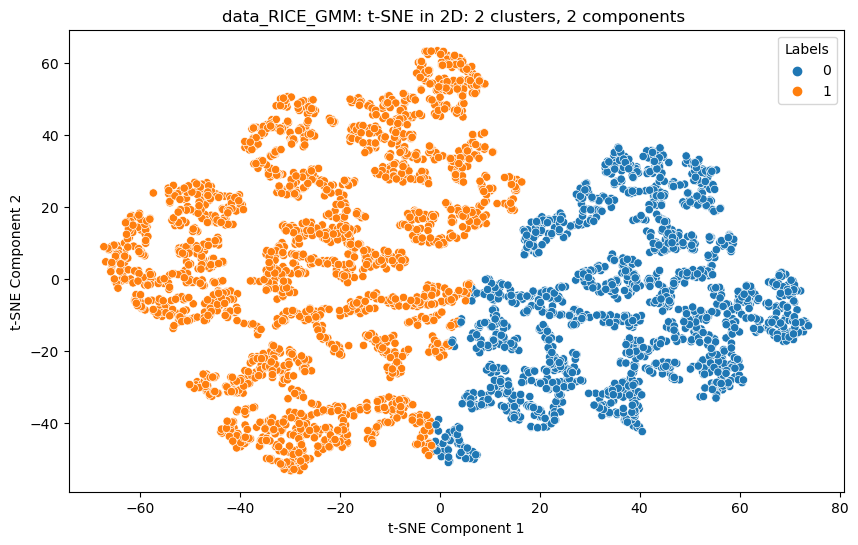

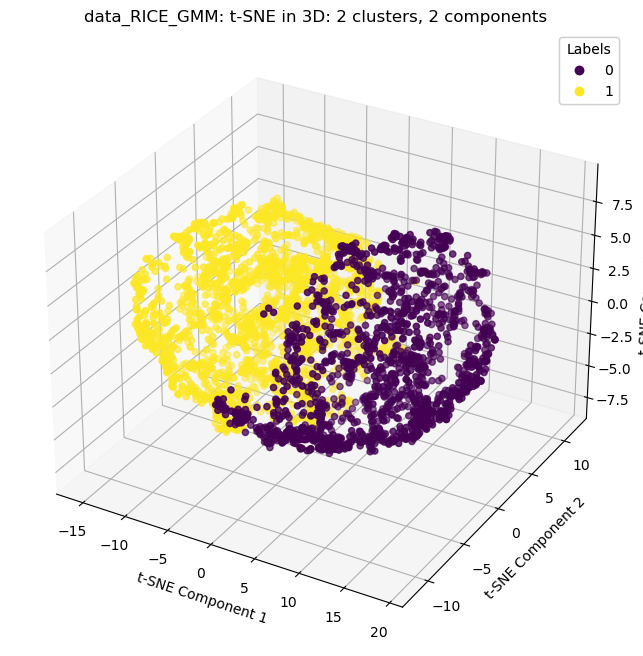

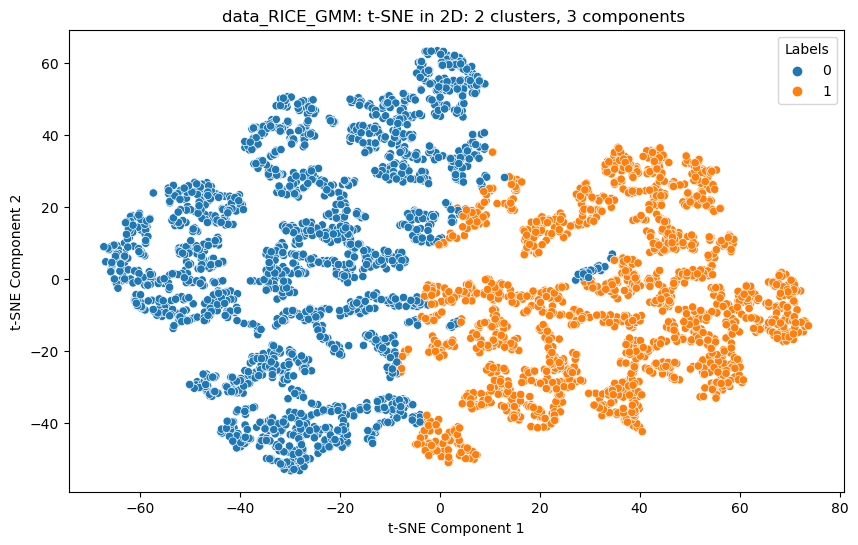

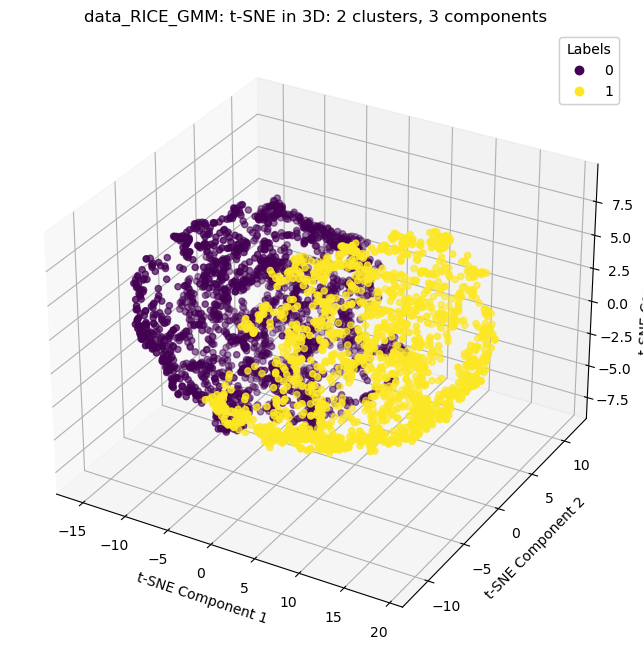

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

n_clusters = 2
n_comp = 2
dataset = dataset
modeltype = "GMM"

for n_clusters in range(2,5):
  for n_comp in range(2,min(X.shape[1], 4)):

    tsne = TSNE(n_components=n_comp )
    X_tsne = tsne.fit_transform(X_std)

    GMM = GaussianMixture(n_components=2) # n pf clusters
    GMM.fit(X_tsne) # using how many componentes generated from t-SNE
    labels = GMM.predict(X_tsne)

    # Visualize t-SNE embeddings in 2D with hue by labels
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_tsne_2[:, 0], y=X_tsne_2[:, 1], hue=labels)
    plt.title(f'{dataset}_{modeltype}: t-SNE in 2D: {n_clusters} clusters, {n_comp} components ')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Labels')
    plt.savefig("Images/"+ f'{dataset}_{modeltype}_2D_{n_clusters}_clusters_{n_comp}_components.png')
    plt.show()

    # Visualize t-SNE embeddings in 3D with hue by labels
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_tsne_3[:, 0], X_tsne_3[:, 1], X_tsne_3[:, 2], c=labels, cmap='viridis')
    ax.set_title(f'{dataset}_{modeltype}: t-SNE in 3D: {n_clusters} clusters, {n_comp} components ')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')
    legend = ax.legend(*scatter.legend_elements(), title="Labels", loc="upper right")
    ax.add_artist(legend)
    plt.savefig("Images/"+ f'{dataset}_{modeltype}_3D_{n_clusters}_clusters_{n_comp}_components.png')
    plt.show()

#### accuracy

Classification Report-_data_RICE_GMM_tsne1:
              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1630
           1       0.96      0.85      0.90      2180

    accuracy                           0.89      3810
   macro avg       0.89      0.90      0.89      3810
weighted avg       0.90      0.89      0.89      3810



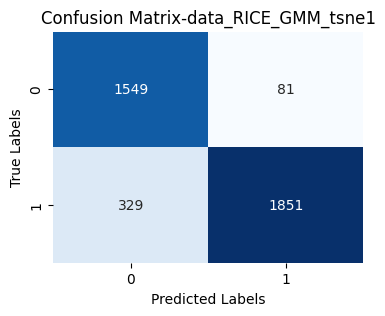

Classification Report-_data_RICE_GMM_tsne2:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1630
           1       0.91      0.94      0.92      2180

    accuracy                           0.91      3810
   macro avg       0.91      0.91      0.91      3810
weighted avg       0.91      0.91      0.91      3810



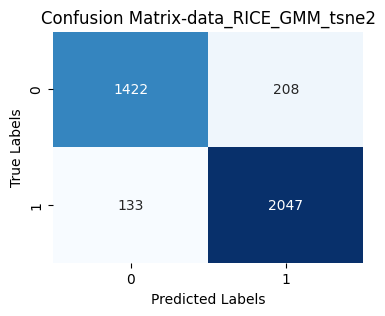

Classification Report-_data_RICE_GMM_tsne3:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1630
           1       0.95      0.91      0.93      2180

    accuracy                           0.92      3810
   macro avg       0.92      0.92      0.92      3810
weighted avg       0.92      0.92      0.92      3810



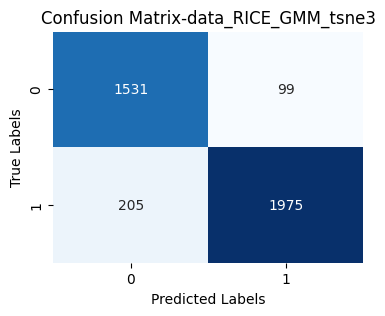

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
model = "GMM"
dr= "tsne"
for n, X_tsne in enumerate([X_tsne_1, X_tsne_2, X_tsne_3]):
# we decide choose two clusters
  GMM2 = GaussianMixture(n_components=2)
  GMM2.fit(X_tsne)
  labels = GMM2.predict(X_tsne)

  # compare actual vs predicted results
  actual_labels = y
  pred_lables = labels


  print(f"Classification Report-_{dataset}_{model}_{dr}{n+1}:")
  print(classification_report(actual_labels, pred_lables))

  # Generate confusion matrix
  plt.figure(figsize=(4, 3))
  cm = confusion_matrix(actual_labels, pred_lables)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.title(f"Confusion Matrix-{dataset}_{model}_{dr}{n+1}")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.savefig(f"plot/confusionMatrix-{dataset}_{model}_{dr}{n+1}.png")
  plt.show()